In [16]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback

import matplotlib.pyplot as plt
import seaborn as sns
import time

In [17]:
path = "./data_12k/Face Mask Dataset/"
dataset = {
    "image_path": [],
    "mask_status": [],
    "where": []
}

for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
            
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,./data_12k/Face Mask Dataset/Test/WithMask\116...,WithMask,Test
1,./data_12k/Face Mask Dataset/Test/WithMask\117...,WithMask,Test
2,./data_12k/Face Mask Dataset/Test/WithMask\117...,WithMask,Test
3,./data_12k/Face Mask Dataset/Test/WithMask\120...,WithMask,Test
4,./data_12k/Face Mask Dataset/Test/WithMask\136...,WithMask,Test


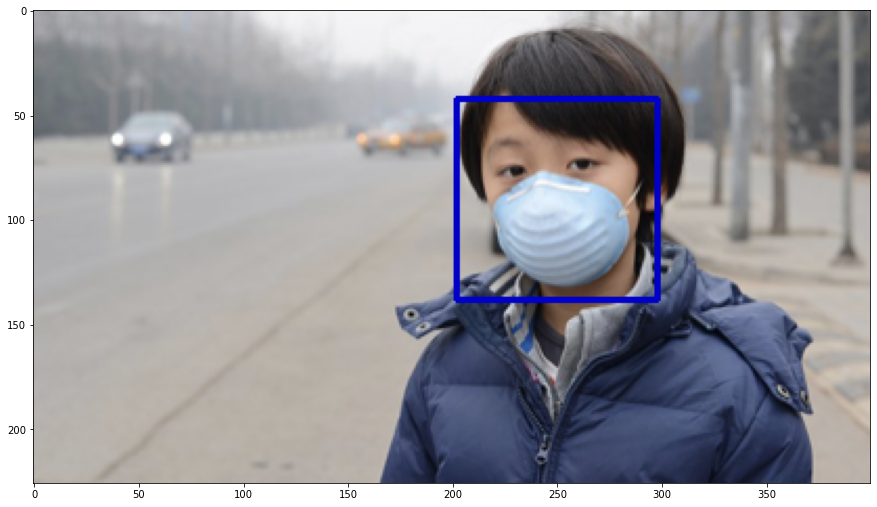

In [18]:
## Choosing a random image to detect the face in the image
cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
haar_model = os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml')
face_model = cv2.CascadeClassifier(haar_model)

## Choosing the image from the directory
img = cv2.imread("./data/images/maksssksksss80.png")

## Converting the image to grayscale to apply haarcascade algorithm
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

## Returns the x, y, w, h co-ordinates as numpy arrays for all the detected faces
detected_face = face_model.detectMultiScale(img)

## Converting from grayscale to colored image
output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

## Drawing rectangle box around the faces in the image
for (x, y, w, h) in detected_face:
    cv2.rectangle(output_img, (x,y), (x+w, y+h), (0, 0, 200), 2)
    
## Displaying the image
plt.figure(figsize = (15, 15))
plt.imshow(output_img)

With Mask: 5909
Without Mask: 5883


<AxesSubplot:xlabel='mask_status', ylabel='count'>

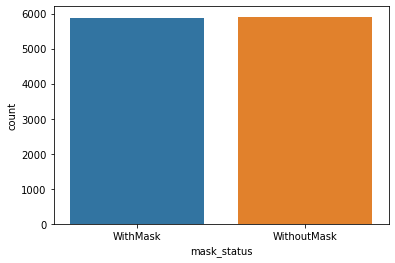

In [19]:
## Checking for total number of images in the dataset
print(f"With Mask:", dataset.value_counts("mask_status")[0])
print(f"Without Mask:", dataset.value_counts("mask_status")[1])

## Plotting the numbers
sns.countplot(x = dataset["mask_status"])

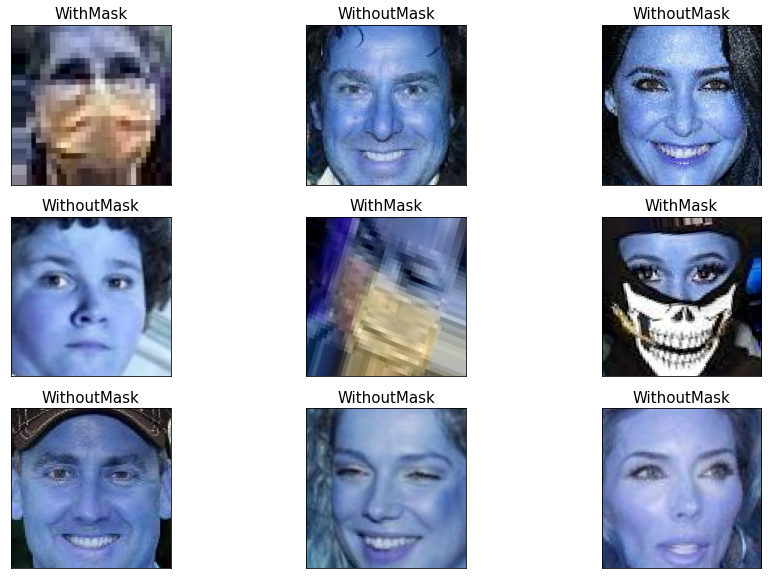

In [20]:
plt.figure(figsize = (15, 10))

for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random,"mask_status"], size = 15)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [21]:
## Splitting train test and Validation Dataset
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

print(train_df.head(10))

## Shuffling the dataset 
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)
valid_df = valid_df.sample(frac = 1)

print("\n After Shuffling \n")
print(train_df.head(10))

                                             image_path mask_status  where
992   ./data_12k/Face Mask Dataset/Train/WithMask\10...    WithMask  Train
993   ./data_12k/Face Mask Dataset/Train/WithMask\10...    WithMask  Train
994   ./data_12k/Face Mask Dataset/Train/WithMask\10...    WithMask  Train
995   ./data_12k/Face Mask Dataset/Train/WithMask\10...    WithMask  Train
996   ./data_12k/Face Mask Dataset/Train/WithMask\10...    WithMask  Train
997   ./data_12k/Face Mask Dataset/Train/WithMask\10...    WithMask  Train
998   ./data_12k/Face Mask Dataset/Train/WithMask\10...    WithMask  Train
999   ./data_12k/Face Mask Dataset/Train/WithMask\10...    WithMask  Train
1000  ./data_12k/Face Mask Dataset/Train/WithMask\10...    WithMask  Train
1001  ./data_12k/Face Mask Dataset/Train/WithMask\10...    WithMask  Train

 After Shuffling 

                                              image_path  mask_status  where
2455   ./data_12k/Face Mask Dataset/Train/WithMask\Au...     WithMask  Train
8

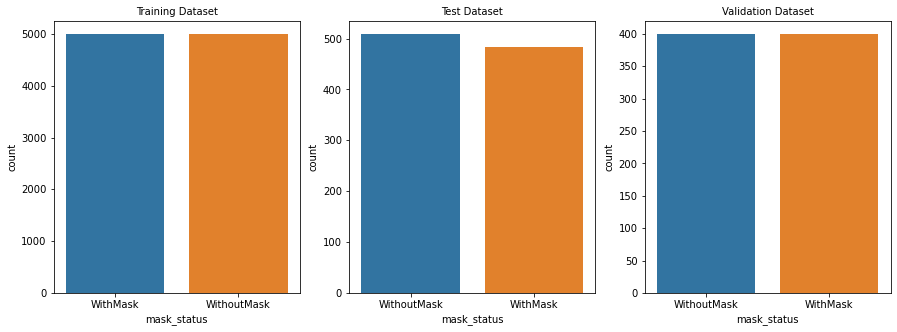

In [22]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df["mask_status"])
plt.title("Training Dataset", size = 10)

plt.subplot(1, 3, 2)
sns.countplot(x = test_df["mask_status"])
plt.title("Test Dataset", size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = valid_df["mask_status"])
plt.title("Validation Dataset", size = 10)

plt.show()

C:\Users\cpata\AppData\Local\Temp/ipykernel_17764/883336621.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


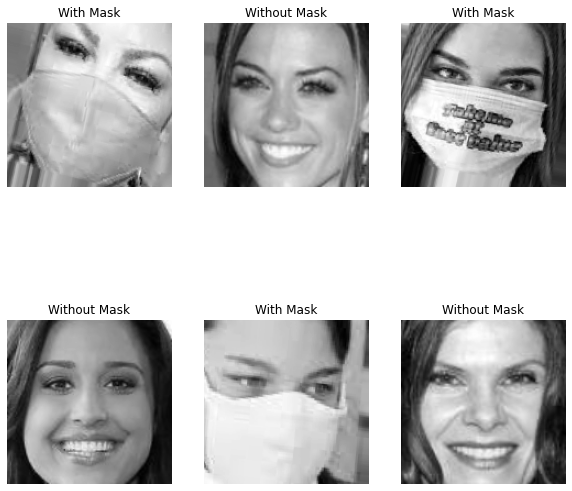

In [23]:
train_df = train_df.reset_index().drop("index", axis = 1)
train_df.head()
## Reading all the image into a list and changing the size of the image to (150,150)
data = []
image_size = 150

for i in range(len(train_df)):
    ## Converting the image into grayscale
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)

    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    ##Encoding the image with the label
    if train_df["mask_status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])
data = np.array(data)
np.random.shuffle(data)
## Looking at the training samples

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for row in range(2):
    for col in range(3):
        image_index = row*100+col
        
        ax[row, col].axis("off")
        ax[row,col].imshow(data[image_index][0], cmap = "gray")
    
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")
            
plt.show()

In [24]:
X = []
y = []

## Seperating X and y
for image in data:
    X.append(image[0])
    y.append(image[1])
    
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X = np.array(X)
y = np.array(y)
### Normalizing the data
X = X/255

### Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [52]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)

classification_metrics=list()
performace_metric=list()

class Metrics(Callback):
    def __init__(self, validation=None):
        super(Metrics, self).__init__()
        self.validation = validation

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:
            x_test, y_test = self.validation[0], self.validation[1]
            y_pred=self.model.predict(x_test)
            y_pred = y_pred[:, 0]
            y_pred = np.where(y_pred > 0.5, 1, 0)
            metric_classification={
                'epoch': epoch,
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'auc': roc_auc_score(y_test, y_pred),
            }
            metric_performace={
                'epoch': epoch,
                'time': time.time() - self.epoch_time_start,
                'accuracy': accuracy_score(y_test, y_pred)
            }
            classification_metrics.append(metric_classification)
            performace_metric.append(metric_performace)

history = model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val), callbacks=[Metrics(validation=(X_val, y_val))])

250/250 [==============================] - 387s 2s/step - loss: 0.0066 - accuracy: 0.9970 - val_loss: 0.1402 - val_accuracy: 0.9710


In [55]:
print(classification_metrics)
print(performace_metric)
model.summary()

[{'epoch': 0, 'accuracy': 0.971, 'precision': 0.9754661432777233, 'recall': 0.9678675754625121, 'auc': 0.9710869223664051}]
[{'epoch': 0, 'time': 386.69759941101074, 'accuracy': 0.971}]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 147456)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               18874496  


In [56]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 14s 226ms/step - loss: 0.1402 - accuracy: 0.9710


[0.14023582637310028, 0.9710000157356262]